# RNN based on time series: Predict Action and next steps

We aim to predict the next steps and actions based on time series

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### Get the data
First Import it using pandas

In [5]:

raw_dataset = pd.read_csv("./data/fromStateToAction_df (28) last.csv")

dataset = raw_dataset.copy()


We need all the path to have the same steps. Therefore we will trunk the path to the same lenght and omit those with reduced lenght

First we check with is the most common lenght

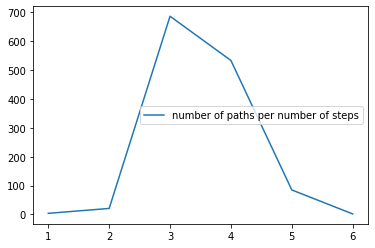

In [6]:
len_stat = dataset.groupby(["id_camino"]).size().reset_index(name='counts')
plt.plot(len_stat.groupby(["counts"]).size(), label ="number of paths per number of steps")
plt.legend()

We will cut at CUT_STEP steps (n=CUT_STEP+1) and remove the path with less than CUT_STEP

In [7]:
# N_STEPS= 3

# long_paths = len_stat[len_stat.counts>N_STEPS]
# red_dataset = dataset.loc[dataset["id_camino"].isin(long_paths["id_camino"])]
# reg_dataset= red_dataset[red_dataset.id_in_seq< (N_STEPS+1)] 

In [7]:
N_CATEGORIES = 28

for index, row in dataset.iterrows():
    CS_array =np.array(eval(row["current_state"]))
    dataset["current_state"][index] = CS_array
    GS_array =np.array(eval(row["goal_state"]))
    dataset["goal_state"][index] = GS_array
    dataset["out_action"][index] = int(dataset["out_action"][index])

# Usar estado final 
dataset["Difference"] =   dataset["goal_state"]-dataset["current_state"]

dataset[["C0",'C1',"C2","C3",'C4',"C5"]] = pd.DataFrame(dataset.current_state.values.tolist(), index= dataset.index)
dataset[["D0",'D1',"D2","D3",'D4',"D5"]] = pd.DataFrame(dataset.Difference.values.tolist(), index= dataset.index)


### Clean the data

We keep the columns we are interested in 

In [44]:
dataset  = dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","out_action"]]


In [45]:
dataset.head()

,id_camino,D0,D1,D2,D3,D4,D5,out_action
0,0,2241.022698,-316.657474,0.461107,0.145088,-0.020134,-0.000762,4
1,0,1745.057520,-267.032650,0.153301,-0.019156,-0.088964,-0.000818,1
2,0,874.820341,-65.086918,-1.045562,0.059299,0.160137,-0.001426,3
3,0,292.139470,-29.003206,0.084644,-0.002623,-0.083223,0.001795,3
4,1,1640.344763,-282.435881,1.053526,0.115329,-0.108648,0.003646,6


## Normalize the data

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [46]:
data_stats = dataset.describe()
data_stats = data_stats.transpose()

In [49]:
def norm(x, train_stats):
  return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(dataset, data_stats)
normed_data.pop("out_action")
normed_data.pop("id_camino")
normed_dataset = normed_data.join(dataset[["out_action","id_camino"]])


In [50]:
normed_dataset

,D0,D1,D2,D3,D4,D5,out_action,id_camino
0,1.597174,-1.701022,0.694298,1.149717,-0.151368,-0.270578,4,0
1,0.844793,-1.353181,0.258761,-0.299719,-0.421934,-0.272760,1,0
2,-0.475359,0.062338,-1.437601,0.392641,0.557264,-0.296318,3,0
3,-1.359287,0.315264,0.161613,-0.153814,-0.399367,-0.171398,3,0
4,0.685944,-1.461149,1.532556,0.887092,-0.499312,-0.099633,6,1
...,...,...,...,...,...,...,...,...
4668,-1.310382,0.387553,-0.851743,-0.844282,-1.889993,1.242704,3,1329
4669,1.410969,-0.341706,1.211883,0.919714,-0.189896,-0.221773,5,1330
4670,0.729329,-0.046772,0.987713,-0.693059,-0.400756,-0.186452,3,1330
4671,-0.120309,0.377121,0.459612,-0.343413,-0.105945,-0.252881,17,1330


## Pad the data

In [144]:
N_STEPS= 3
PAD_LEN = N_STEPS+1

In [145]:
padded_data = []
for camino in normed_dataset["id_camino"]:
    group = normed_dataset[normed_dataset["id_camino"]==camino]
    group.pop("id_camino")
    padded_data.append(group.values)

In [146]:
dataset2 = tf.keras.preprocessing.sequence.pad_sequences(padded_data, maxlen=PAD_LEN, dtype='float64', padding='pre', truncating='pre', value=0.0)
dataset2[9]

array([[ 1.16414962, -0.99859692,  0.46871019,  1.20112044,  0.11262316,
        -0.41473824,  4.        ],
       [ 0.4117691 , -0.6507564 ,  0.03317248, -0.24831561, -0.15794313,
        -0.41692087,  2.        ],
       [-0.60139949, -0.040385  , -0.56412469,  0.1324287 ,  0.21002957,
        -0.37724571,  2.        ],
       [-1.62101257,  0.50575168, -0.64401972,  0.14390399,  0.28123166,
        -0.41044529,  3.        ]])

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [147]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## Single Step model

### Split features from labels

In [148]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="single_step"
features_dataset = dataset2
target_dataset = dataset2[:,:,6]

x_train_single, y_train_single = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single, y_val_single = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [149]:
x_train_single[9]

array([[ 1.16414962, -0.99859692,  0.46871019,  1.20112044,  0.11262316,
        -0.41473824,  4.        ],
       [ 0.4117691 , -0.6507564 ,  0.03317248, -0.24831561, -0.15794313,
        -0.41692087,  2.        ],
       [-0.60139949, -0.040385  , -0.56412469,  0.1324287 ,  0.21002957,
        -0.37724571,  2.        ]])

In [150]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (3, 7)


In [151]:
y_train_single[9]

3.0

In [152]:
training_size = len(x_train_single)
training_size

3738

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [153]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [154]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(10,return_sequences=False, input_shape=x_train_single.shape[-2:], ))
single_step_model.add(tf.keras.layers.Dense(N_CATEGORIES, activation="softmax"))

single_step_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [155]:
single_step_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                720       
_________________________________________________________________
dense_2 (Dense)              (None, 28)                308       
Total params: 1,028
Trainable params: 1,028
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of BATCH_SIZE examples from the training data and call `model.predict` on it.

In [156]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)


(20, 28)


It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [157]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 186.9 steps, validate for 50 steps
Epoch 1/20
187/186 [==============================] - 7s 38ms/step - loss: 3.3200 - accuracy: 0.1423 - val_loss: 3.3074 - val_accuracy: 0.1035
Epoch 2/20
187/186 [==============================] - 1s 8ms/step - loss: 3.2684 - accuracy: 0.1958 - val_loss: 3.2815 - val_accuracy: 0.1025
Epoch 3/20
187/186 [==============================] - 2s 10ms/step - loss: 3.2282 - accuracy: 0.2049 - val_loss: 3.2633 - val_accuracy: 0.1116
Epoch 4/20
187/186 [==============================] - 2s 9ms/step - loss: 3.1883 - accuracy: 0.2071 - val_loss: 3.2414 - val_accuracy: 0.1206
Epoch 5/20
187/186 [==============================] - 2s 9ms/step - loss: 3.1607 - accuracy: 0.2515 - val_loss: 3.2156 - val_accuracy: 0.1678
Epoch 6/20
187/186 [==============================] - 2s 9ms/step - loss: 3.1332 - accuracy: 0.2876 - val_loss: 3.1913 - val_accuracy: 0.2231
Epoch 7/20
187/186 [==============================] - 2s 10ms/step - loss: 3.1080 - accuracy: 0.3277 

In [158]:
test_loss, test_acc = single_step_model.evaluate(x_val_single,  y_val_single, verbose=2)

print('\nTest accuracy:', test_acc)

935/935 - 1s - loss: 3.1013 - accuracy: 0.3070

Test accuracy: 0.30695188


Visualize the model's training progress.

In [159]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

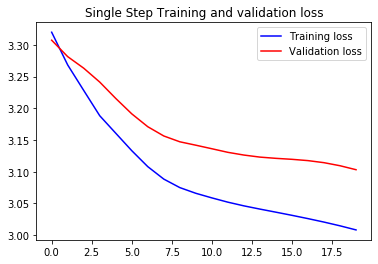

In [160]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

Let's include early stop to avoid overfitting

In [118]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.4513,  loss:2.9406,  val_accuracy:0.4442,  val_loss:2.9479,  
....................

In [119]:
test_loss, test_acc = single_step_model.evaluate(x_val_single,  y_val_single, verbose=2)

print('\nTest accuracy:', test_acc)

935/935 - 0s - loss: 2.9151 - accuracy: 0.4759

Test accuracy: 0.47593582


## Adding embedding layer

### Build de model

In [202]:
# Embedding
input_1 = tf.keras.layers.Input(shape=(past_history), name='action')
embedding = tf.keras.layers.Embedding(28, 5, input_length=past_history, name='embedding')(input_1)

#Features
input_2 = tf.keras.layers.Input(shape=(past_history, 6), name='features')

#Concatenation
concat = tf.keras.layers.concatenate([embedding, input_2], name='concat')

# RNN
RNN = tf.keras.layers.LSTM(11,return_sequences=False,name='RNN')(concat)
output= tf.keras.layers.Dense(N_CATEGORIES, activation="softmax", name='output')(RNN)

full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

full_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'), metrics=['accuracy'])

print(full_model.summary())

keras.utils.plot_model(full_model, 'full_model.png', show_shapes=True)




Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
action (InputLayer)             [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3, 5)         140         action[0][0]                     
__________________________________________________________________________________________________
features (InputLayer)           [(None, 3, 6)]       0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 3, 11)        0           embedding[0][0]                  
                                                                 features[0][0]            

In [205]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_history = full_model.fit({'features': x_train_single[:,:,0:6], 'action': x_train_single[:,:,6]},y_train_single, validation_data=({'features': x_val_single[:,:,0:6], 'action': x_val_single[:,:,6]}, y_val_single), epochs=EPOCHS)

Train on 3738 samples, validate on 935 samples
Epoch 1/20
3738/3738 [==============================] - 3s 772us/sample - loss: 2.9766 - accuracy: 0.4294 - val_loss: 3.0522 - val_accuracy: 0.3390
Epoch 2/20
3738/3738 [==============================] - 1s 285us/sample - loss: 2.9730 - accuracy: 0.4331 - val_loss: 3.0486 - val_accuracy: 0.3390
Epoch 3/20
3738/3738 [==============================] - 1s 280us/sample - loss: 2.9701 - accuracy: 0.4353 - val_loss: 3.0487 - val_accuracy: 0.3401
Epoch 4/20
3738/3738 [==============================] - 1s 311us/sample - loss: 2.9636 - accuracy: 0.4374 - val_loss: 3.0448 - val_accuracy: 0.3348
Epoch 5/20
3738/3738 [==============================] - 1s 284us/sample - loss: 2.9418 - accuracy: 0.4866 - val_loss: 3.0283 - val_accuracy: 0.3914
Epoch 6/20
3738/3738 [==============================] - 1s 292us/sample - loss: 2.9289 - accuracy: 0.5016 - val_loss: 3.0195 - val_accuracy: 0.3914
Epoch 7/20
3738/3738 [==============================] - 1s 319us/

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [161]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2
target_dataset = dataset2[:,:,6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [162]:
x_train_single_sequential[0]

array([[ 1.59717363, -1.70102178,  0.6942984 ,  1.1497174 , -0.15136753,
        -0.27057772,  4.        ],
       [ 0.84479311, -1.35318126,  0.25876069, -0.29971865, -0.42193381,
        -0.27276035,  1.        ],
       [-0.47535904,  0.06233832, -1.43760069,  0.39264118,  0.55726444,
        -0.29631792,  3.        ]])

In [163]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (3, 7)


In [164]:
y_train_single_sequential[0]

array([1., 3., 3.])

In [165]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [166]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=x_train_single_sequential.shape[-2:], ))
single_step_sequential_model.add(tf.keras.layers.Dense(N_CATEGORIES, activation="softmax"))

single_step_sequential_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'),
              metrics=['accuracy'])

### Inspect the model

In [167]:
single_step_sequential_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 11)             836       
_________________________________________________________________
dense_3 (Dense)              (None, 3, 28)             336       
Total params: 1,172
Trainable params: 1,172
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [168]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 186.9 steps, validate for 50 steps
Epoch 1/20
187/186 [==============================] - 12s 65ms/step - loss: 3.3195 - accuracy: 0.1181 - val_loss: 3.3020 - val_accuracy: 0.1022
Epoch 2/20
187/186 [==============================] - 2s 9ms/step - loss: 3.2732 - accuracy: 0.1533 - val_loss: 3.2758 - val_accuracy: 0.1461
Epoch 3/20
187/186 [==============================] - 2s 9ms/step - loss: 3.2350 - accuracy: 0.2068 - val_loss: 3.2381 - val_accuracy: 0.2054
Epoch 4/20
187/186 [==============================] - 2s 8ms/step - loss: 3.1876 - accuracy: 0.2554 - val_loss: 3.2080 - val_accuracy: 0.2137
Epoch 5/20
187/186 [==============================] - 2s 9ms/step - loss: 3.1631 - accuracy: 0.2648 - val_loss: 3.1954 - val_accuracy: 0.2184
Epoch 6/20
187/186 [==============================] - 2s 9ms/step - loss: 3.1507 - accuracy: 0.2669 - val_loss: 3.1877 - val_accuracy: 0.2248
Epoch 7/20
187/186 [==============================] - 2s 8ms/step - loss: 3.1428 - accuracy: 0.2677 -

In [173]:
test_loss, test_acc = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

935/935 - 0s - loss: 3.1238 - accuracy: 0.2713


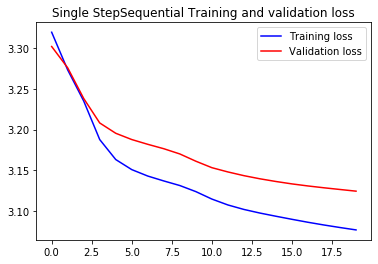

In [170]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

### Corrected accuracy for one step (instead the full sequence)

In [172]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy()   
_ = m.update_state(y_val_single_sequential[:,N_STEPS-1], Last_step_prediction.argmax(axis=1)) 
m.result().numpy() 

0.22673796

In [174]:
y_val_single_sequential[:,N_STEPS-1]

array([ 5.,  5.,  3.,  3.,  3., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,
        2.,  2.,  2., 23., 23., 23., 27., 27., 27., 27.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6., 10., 10., 10.,
        3.,  3.,  3., 24., 24., 24.,  3.,  3.,  3.,  3., 10., 10., 10.,
        2.,  2.,  2.,  2., 12., 12., 12., 12., 12., 24., 24., 24., 24.,
        3.,  3.,  3., 18., 18., 18., 18., 18.,  3.,  3.,  3.,  3.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,
       18., 18., 18., 18., 16., 16., 16., 11., 11., 11.,  4.,  4.,  4.,
        4.,  2.,  2.,  2.,  3.,  3.,  3.,  5.,  5.,  5.,  5.,  5.,  4.,
        4.,  4.,  4.,  4.,  4.,  4., 10., 10., 10.,  4.,  4.,  4., 23.,
       23., 23., 18., 18., 18., 18.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       10., 10., 10., 10., 10., 17., 17., 17., 17.,  2.,  2.,  2.,  2.,
       10., 10., 10., 10., 10., 10., 10., 10.,  2.,  2.,  2.,  6

In [175]:
Last_step_prediction.argmax(axis=1)

array([ 5,  5,  5,  5,  5, 23, 23, 23, 23,  5,  5,  5,  5,  5,  5,  5, 23,
       23, 23,  5,  5,  5,  5,  2,  2,  2,  2,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  2,  2,  2, 23, 23, 23,  5,  5,  5,  5, 23, 23,
       23,  2,  2,  2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,  2,  2,  2,  2,  2, 23,
       23, 23,  5,  5,  5,  5, 23, 23, 23,  5,  5,  5,  5,  5,  5,  5,  2,
        2,  2,  2,  2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        2,  2,  2,  2,  2,  2, 23, 23, 23,  5,  5,  5,  5,  1,  1,  1,  1,
        1,  1,  1, 23, 23, 23, 23, 23, 23, 23, 23, 23,  2,  2,  2,  2,  5,
        5,  5,  5,  5, 23, 23, 23,  5,  5,  5,  2,  2,  2,  1,  1,  5,  5,
        5,  5,  5,  5,  5,  5, 23, 23, 23,  1,  1,  1,  1,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,  5,  5,  5,  5,
       23, 23, 23,  2,  2

#### Adding early stop

In [238]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.2972,  loss:3.0924,  val_accuracy:0.2450,  val_loss:3.1539,  
....................

In [239]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy()   
_ = m.update_state(y_val_single_sequential[:,N_STEPS-1], Last_step_prediction.argmax(axis=1)) 
m.result().numpy() 

0.4755245

## Adding embedding layer

### Build the model (multiple output)

In [209]:
# Embedding
input_1 = tf.keras.layers.Input(shape=(past_history), name='action')
embedding = tf.keras.layers.Embedding(28, 5, input_length=past_history, name='embedding')(input_1)

#Features
input_2 = tf.keras.layers.Input(shape=(past_history, 6), name='features')

#Concatenation
concat = tf.keras.layers.concatenate([embedding, input_2], name='concat')

# RNN
RNN = tf.keras.layers.LSTM(11,return_sequences=True, name='RNN')(concat)
output= tf.keras.layers.Dense(N_CATEGORIES, activation="softmax", name='output')(RNN)

full_model_sequential= tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

full_model_sequential.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'), metrics=['accuracy'])

print(full_model_sequential.summary())

keras.utils.plot_model(full_model_sequential, 'full_model.png', show_shapes=True)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
action (InputLayer)             [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3, 5)         140         action[0][0]                     
__________________________________________________________________________________________________
features (InputLayer)           [(None, 3, 6)]       0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 3, 11)        0           embedding[0][0]                  
                                                                 features[0][0]            

In [210]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = full_model_sequential.fit({'features': x_train_single_sequential[:,:,0:6], 'action': x_train_single_sequential[:,:,6]},y_train_single_sequential, validation_data=({'features': x_val_single_sequential[:,:,0:6], 'action': x_val_single_sequential[:,:,6]}, y_val_single_sequential), epochs=EPOCHS)

Train on 3738 samples, validate on 935 samples
Epoch 1/20
3738/3738 [==============================] - 11s 3ms/sample - loss: 3.3258 - accuracy: 0.1317 - val_loss: 3.3123 - val_accuracy: 0.1308
Epoch 2/20
3738/3738 [==============================] - 1s 310us/sample - loss: 3.2764 - accuracy: 0.1455 - val_loss: 3.2436 - val_accuracy: 0.2175
Epoch 3/20
3738/3738 [==============================] - 1s 328us/sample - loss: 3.1999 - accuracy: 0.2412 - val_loss: 3.1854 - val_accuracy: 0.2453
Epoch 4/20
3738/3738 [==============================] - 1s 327us/sample - loss: 3.1573 - accuracy: 0.2497 - val_loss: 3.1651 - val_accuracy: 0.2410
Epoch 5/20
3738/3738 [==============================] - 1s 326us/sample - loss: 3.1400 - accuracy: 0.2557 - val_loss: 3.1569 - val_accuracy: 0.2417
Epoch 6/20
3738/3738 [==============================] - 1s 328us/sample - loss: 3.1292 - accuracy: 0.2722 - val_loss: 3.1537 - val_accuracy: 0.2385
Epoch 7/20
3738/3738 [==============================] - 1s 335us/s

In [212]:
Last_step_prediction = full_model_sequential.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy()   
_ = m.update_state(y_val_single_sequential[:,N_STEPS-1], Last_step_prediction.argmax(axis=1)) 
m.result().numpy()

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), for inputs ['action', 'features'] but instead got the following list of 1 arrays: [array([[[ 1.42813376e+00, -5.21801276e-01,  3.02302893e-01, ...,
          1.88967202e-01, -2.37300531e-01,  9.00000000e+00],
        [ 1.68427440e-01, -1.99780207e-01, -1.06808027e+00, ...,
        ...

## Predict a single step future

In [240]:
probability_model = tf.keras.Sequential([single_step_model, 
                                         tf.keras.layers.Softmax()])

In [241]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [242]:
def create_time_steps(length):
  return list(range(-length, 0))

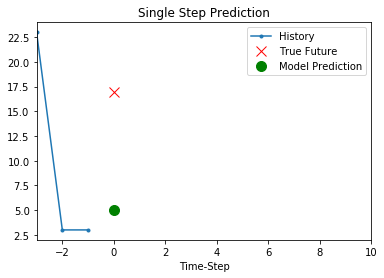

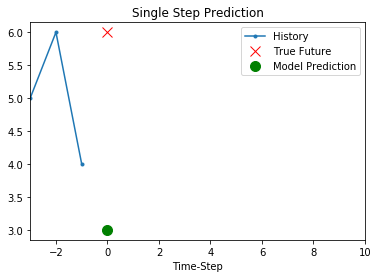

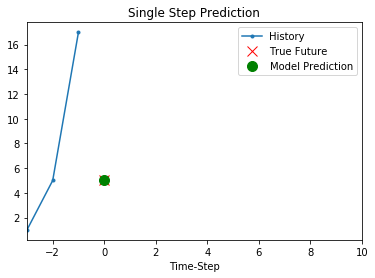

In [243]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 6].numpy(), y[0].numpy(),
                    np.argmax(probability_model.predict(x)[0])], 0,
                   'Single Step Prediction')
  plot.show()

# Multi-Step model

In [244]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
future_target = 2
STEP = N_STEPS+1
past_history = STEP - future_target
prediction_type ="multiple_step"

x_train_multi, y_train_multi = multivariate_data(dataset2, dataset2[:, 6], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   prediction_type)
x_val_multi, y_val_multi = multivariate_data(dataset2, dataset2[:, 6],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               prediction_type)

We check that the data and label sets have the correct size

In [245]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target Action to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (2, 7)

 Target Action to predict : (2,)


We prepate the chunks

In [246]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

We plot a true future

In [247]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 6]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

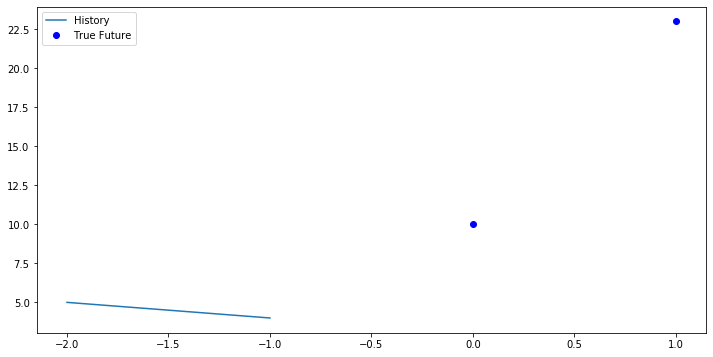

In [248]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Here is the model with 2 layers. The last layer has the number of predictions as outputs

In [249]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(N_CATEGORIES,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(N_CATEGORIES, activation='softmax'))

multi_step_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='sparse_categorical_crossentropy'),
              metrics=['accuracy'])

In [250]:
multi_step_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 2, 28)             4032      
_________________________________________________________________
dense_12 (Dense)             (None, 2, 28)             812       
Total params: 4,844
Trainable params: 4,844
Non-trainable params: 0
_________________________________________________________________


This is the prediction shape, which should be (BATCHSIZE, # predicted points)

In [251]:
for x, y in val_data_multi.take(1):
  print (tf.shape(multi_step_model.predict(x)))

tf.Tensor([20  2 28], shape=(3,), dtype=int32)


We train the model

In [252]:
EPOCHS = 100

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 28.6 steps, validate for 50 steps
Epoch 1/100
29/28 [==============================] - 9s 295ms/step - loss: 3.3266 - accuracy: 0.1728 - val_loss: 3.3209 - val_accuracy: 0.2183
Epoch 2/100
29/28 [==============================] - 0s 11ms/step - loss: 3.3032 - accuracy: 0.3010 - val_loss: 3.2918 - val_accuracy: 0.2288
Epoch 3/100
29/28 [==============================] - 0s 12ms/step - loss: 3.2295 - accuracy: 0.3019 - val_loss: 3.1989 - val_accuracy: 0.2294
Epoch 4/100
29/28 [==============================] - 0s 13ms/step - loss: 3.1295 - accuracy: 0.3019 - val_loss: 3.1304 - val_accuracy: 0.2333
Epoch 5/100
29/28 [==============================] - 0s 12ms/step - loss: 3.0819 - accuracy: 0.3019 - val_loss: 3.1146 - val_accuracy: 0.2361
Epoch 6/100
29/28 [==============================] - 0s 11ms/step - loss: 3.0574 - accuracy: 0.3264 - val_loss: 3.1090 - val_accuracy: 0.2467
Epoch 7/100
29/28 [==============================] - 0s 13ms/step - loss: 3.0377 - accuracy: 0.3560 - v

In [253]:
test_loss, test_acc = multi_step_model.evaluate(x_val_multi,  y_val_multi, verbose=2)

print('\nTest accuracy:', test_acc)

143/143 - 1s - loss: 3.1293 - accuracy: 0.2587

Test accuracy: 0.25874126


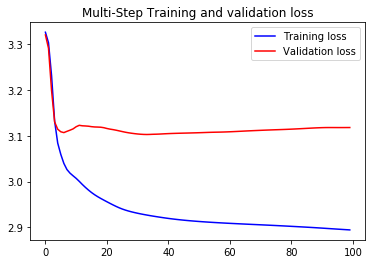

In [254]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [255]:
hist = pd.DataFrame(multi_step_history.history)
hist['epoch'] = multi_step_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,2.895943,0.505236,3.118176,0.256682,95
96,2.895511,0.506108,3.118173,0.253341,96
97,2.895081,0.506108,3.118194,0.256682,97
98,2.894652,0.506981,3.118228,0.260022,98
99,2.894222,0.506981,3.118262,0.260022,99


In [256]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'Accuracy [Action]')

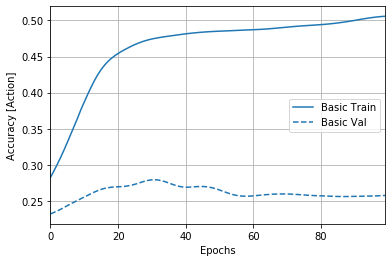

In [257]:
plotter.plot({'Basic': multi_step_history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

In [258]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])





Epoch: 0, accuracy:0.5070,  loss:2.8938,  val_accuracy:0.2639,  val_loss:3.1183,  
..........................

In [259]:
test_loss, test_acc = multi_step_model.evaluate(x_val_multi,  y_val_multi, verbose=2)

print('\nTest accuracy:', test_acc)

143/143 - 0s - loss: 3.1218 - accuracy: 0.2797

Test accuracy: 0.27972028


Text(0, 0.5, 'Accuracy [Action]')

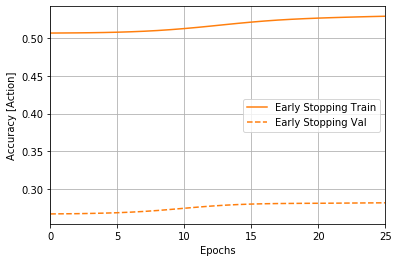

In [260]:
plotter.plot({'Early Stopping': early_history}, metric = "accuracy")
plt.ylabel('Accuracy [Action]')

let's check the predictions

In [261]:
probability_multi_model = tf.keras.Sequential([multi_step_model, 
                                         tf.keras.layers.Softmax()])

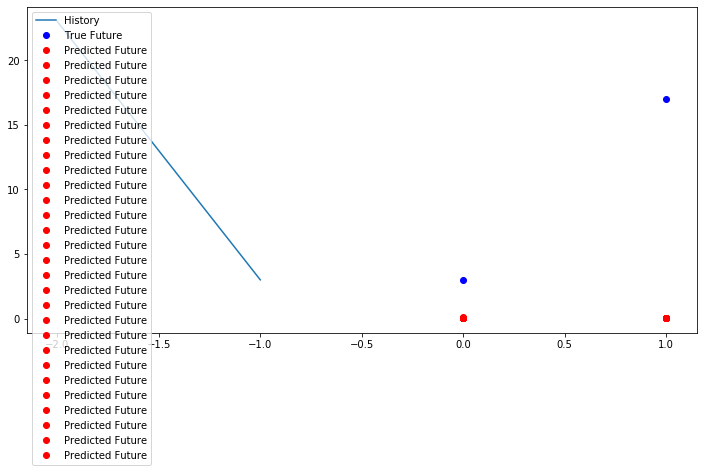

In [262]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], probability_multi_model.predict(x)[0])